In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import random
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from tensorflow.keras.utils import to_categorical
import glob
# Configurations
IMAGE_PATH = '2D_Sliced_Images/'
MASK_PATH = '2D_Sliced_Masks/'
IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 8
EPOCHS = 5
NUM_CLASSES = 3
n_classes=3 #Number of classes for segmentation


In [2]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob(r"D:\python\Hapetic2\2D_Sliced_Images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)       
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob(r"D:\python\Hapetic2\2D_Sliced_Masks"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [3]:
train_images.shape, train_masks.shape  # Check the shape of the images and masks

((4416, 256, 256), (4416, 256, 256))

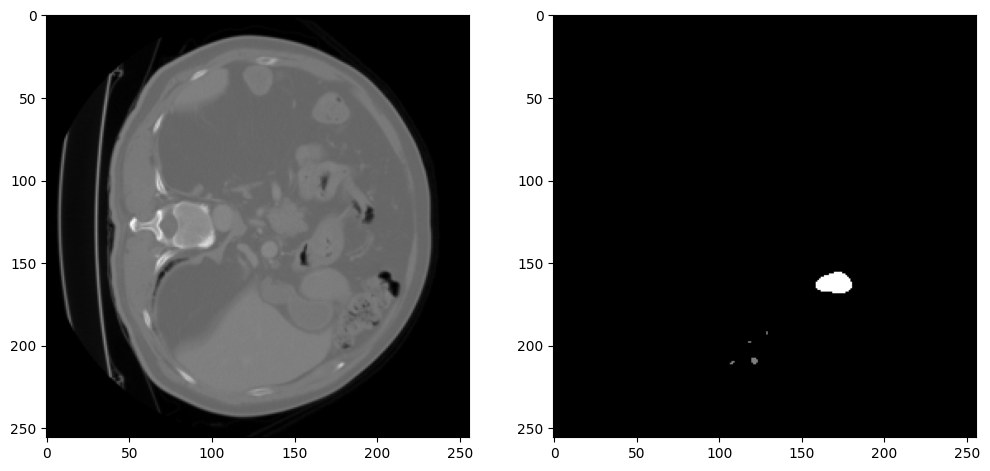

In [4]:
image_number = random.randint(0, len(train_images) - 1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(train_images[image_number], cmap='gray')
plt.subplot(122)
plt.imshow(train_masks[image_number], cmap='gray')
plt.show()

In [5]:
# First split into 80% train+validation and 20% test
train_val_images, test_images, train_val_masks, test_masks = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=42
)

# Further split the 80% train+validation into 75% train and 25% validation
train_images, val_images, train_masks, val_masks = train_test_split(
    train_val_images, train_val_masks, test_size=0.25, random_state=42
)  # 0.25 x 0.8 = 0.2 validation

# Print shapes to verify
print("Training images shape:", train_images.shape)
print("Training masks shape:", train_masks.shape)

Training images shape: (2649, 256, 256)
Training masks shape: (2649, 256, 256)


In [6]:
# Normalize images to the range [0, 1]
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0


In [7]:

# Ensure masks are integers before one-hot encoding
train_masks = train_masks.astype(np.int32)
val_masks = val_masks.astype(np.int32)
test_masks = test_masks.astype(np.int32)

In [8]:
# Define a generator for one-hot encoding in batches
def one_hot_encode_generator(masks, num_classes):
	for mask in masks:
		yield to_categorical(mask, num_classes=num_classes)

# Ensure mask values are within the valid range [0, NUM_CLASSES-1]
train_masks = np.clip(train_masks, 0, NUM_CLASSES - 1)
val_masks = np.clip(val_masks, 0, NUM_CLASSES - 1)
test_masks = np.clip(test_masks, 0, NUM_CLASSES - 1)

# Apply one-hot encoding using the generator
train_masks = np.array([to_categorical(mask, num_classes=NUM_CLASSES) for mask in train_masks])
val_masks = np.array([to_categorical(mask, num_classes=NUM_CLASSES) for mask in val_masks])
test_masks = np.array([to_categorical(mask, num_classes=NUM_CLASSES) for mask in test_masks])

# Add channel dimension to training, validation, and test images
train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# Print shapes to verify
print("Training images shape:", train_images.shape)
print("Training masks shape:", train_masks.shape)
print("Validation images shape:", val_images.shape)
print("Validation masks shape:", val_masks.shape)
print("Test images shape:", test_images.shape)
print("Test masks shape:", test_masks.shape)

Training images shape: (2649, 256, 256, 1)
Training masks shape: (2649, 256, 256, 3)
Validation images shape: (883, 256, 256, 1)
Validation masks shape: (883, 256, 256, 3)
Test images shape: (884, 256, 256, 1)
Test masks shape: (884, 256, 256, 3)


In [10]:
# Define a simple U-Net-like model for segmentation
def build_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    # Encoder
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    
    # Bottleneck
    bottleneck = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    
    # Decoder
    up1 = layers.UpSampling2D((2, 2))(bottleneck)
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    
    up2 = layers.UpSampling2D((2, 2))(conv3)
    conv4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
    
    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(conv4)
    
    model = keras.Model(inputs, outputs)
    return model